## PROJECT-3. Анализ воронки

*Работу подготовила: Машковцева Дарья.*

ЦЕЛЬ

Исследовать поведение пользователей в обновлённом приложении.

ЗАДАЧИ

В рамках проверки гипотез вам необходимо решить три задачи:
1. Определить, насколько обучение сокращает время прохождения этапов игры.
2. Доказать, что успешное обучение само по себе влияет на оплату и не имеет значения то, каким этапом оно шло.
3. Определить, насколько прозрачен процесс взаимодействия с игрой.

КОНКРЕТНЫЕ ШАГИ (ФОРМАЛИЗОВАННЫЕ ЗАДАЧИ)
1. Сравнить время прохождения различных этапов для пользователей, которые завершили обучение, и пользователей, не начинавших обучение. Если показатель отличается, выяснить, насколько.
2. Проверить, существует ли зависимость между вероятностью оплаты вопросов и количеством обучений, которые начинал или завершал пользователь. 
3. Выяснить, как часто пользователи начинают обучение после выбора уровня сложности. (Это позволит оценить прозрачность процесса взаимодействия с игрой: если пользователи после выбора уровня сложности обращаются к обучению, значит, работа с приложением непонятна.)

In [1]:
import pandas as pd

events_data = pd.read_csv('data/7_4_Events.csv', sep=',')
purchase_data = pd.read_csv('data/purchase.csv', sep=',')

*Подготовка данных*

In [3]:
cond = (events_data.start_time>='2018-01-01') & (events_data.start_time<'2019-01-01') & (events_data.event_type=='registration')
registered = events_data[cond]['user_id'].to_list() # список пользователей, зарег. в 2018
events_df = events_data[events_data.user_id.isin(registered)]
events_df.start_time = pd.to_datetime(events_df.start_time, format='%Y-%m-%dT%H:%M:%S')

cond2 = (purchase_data.event_datetime>='2018-01-01') & (purchase_data.event_datetime<'2019-01-01')
registered2 = purchase_data[cond2]['user_id'].to_list()
purchase_df = purchase_data[purchase_data['user_id'].isin(registered)]
purchase_df.event_datetime = pd.to_datetime(purchase_df.event_datetime, format='%Y-%m-%dT%H:%M:%S')

*Объединяем таблицы*

In [5]:
purchase_df['event_type'] = 'purchase'
events_df = events_df.rename(columns={"id": "event_id"})
purchase_df = purchase_df.rename(columns={"id": "purchase_id"})
purchase_df = purchase_df.rename(columns={"event_datetime": "start_time"})
total_events_df = pd.concat([events_df,purchase_df],sort=False)

total_events_df = total_events_df.reset_index(drop=True).sort_values('start_time')

#### 1. Насколько обучение сокращает время прохождения этапов игры?

*Получаем список уникальных пользователей*

In [6]:
all_users = total_events_df["user_id"].unique()
users_df = pd.DataFrame(all_users, columns = ['user_id'])

*Ищем пользователей, прошедших обучение хотя бы раз*

In [33]:
users_with_finished_tutorial = total_events_df[total_events_df["event_type"] == "tutorial_finish"]["user_id"].unique()
users_with_finished_tutorial_df = total_events_df[total_events_df["user_id"].isin(set(users_with_finished_tutorial))]

df1 = pd.DataFrame(users_with_finished_tutorial_df["user_id"].unique(), columns = ['user_id'])
df1['status'] = 'tutorial_finish'

*Ищем пользователей, которые начали, но не закончили обучение*

In [34]:
users_with_started_tutorial = total_events_df[total_events_df["event_type"] == "tutorial_start"]["user_id"].unique()
set_users_with_started_tutorial = set(users_with_started_tutorial)
set_users_not_finished_but_started_tutorial = (set_users_with_started_tutorial.difference(set(users_with_finished_tutorial)))
users_not_finished_but_started_tutorial_df = total_events_df[total_events_df["user_id"].isin(set_users_not_finished_but_started_tutorial)]

df2 = pd.DataFrame(users_not_finished_but_started_tutorial_df["user_id"].unique(), columns = ['user_id'])
df2['status'] = 'not_finished_but_started_tutorial'

*Ищем пользователей, ни разу не начинавших обучение*

In [35]:
set_all_users = set(all_users)
set_users_not_started_tutorial = set_all_users.difference(set(users_with_started_tutorial))
users_not_started_tutorial_df = total_events_df[total_events_df["user_id"].isin(set_users_not_started_tutorial)]

df3 = pd.DataFrame(users_not_started_tutorial_df["user_id"].unique(), columns = ['user_id'])
df3['status'] = 'not_tutorial_start'

*Объединяем датафреймы со статусами*

In [37]:
t = df1.merge(df2, how='outer')
t = t.merge(df3, how='outer')

*Определяем время между этапами*

In [39]:
registration_df = total_events_df[total_events_df['event_type'] == 'registration']
registration_df = registration_df[["user_id", "start_time"]].rename(columns={"start_time": "registration_time"})

tutorial_start_df = total_events_df[total_events_df['event_type'] == 'tutorial_start']
tutorial_start_df_wo_duplicates = tutorial_start_df.sort_values("start_time").drop_duplicates("user_id")
tutorial_start_df_wo_duplicates = tutorial_start_df_wo_duplicates[["user_id", "tutorial_id", "start_time"]].rename(columns={"start_time": "tutorial_start_time"})

level_choice_df = total_events_df[total_events_df["event_type"] == "level_choice"]
level_choice_df = level_choice_df[["user_id", "start_time"]].rename(columns={"start_time": "level_choice_time"})

pack_choice_df = total_events_df[total_events_df["event_type"] == "pack_choice"]
pack_choice_df = pack_choice_df[["user_id", "start_time"]].rename(columns={"start_time": "pack_choice_time"})

stage_purchase_df = total_events_df[total_events_df["event_type"] == "purchase"]
stage_purchase_df = stage_purchase_df[["user_id", "start_time"]].rename(columns={"start_time": "purchase_time"})

merged_df = registration_df.merge(tutorial_start_df_wo_duplicates, on="user_id", how="inner")
merged_df["registration"] = (merged_df["tutorial_start_time"] - merged_df["registration_time"])

merged_df = merged_df.merge(level_choice_df, on="user_id", how="inner")
merged_df = merged_df.merge(pack_choice_df, on="user_id", how="inner")
merged_df["level_choice"] = (merged_df["pack_choice_time"] - merged_df["level_choice_time"])

merged_df = merged_df.merge(stage_purchase_df, on="user_id", how="inner")
merged_df["pack_choice"] = (merged_df["purchase_time"] - merged_df["pack_choice_time"])
merged_df["purchase"] = (merged_df["purchase_time"] - merged_df["registration_time"])

timedelta_users = merged_df[['user_id', "registration", 'level_choice', 'pack_choice', 'purchase']]

In [42]:
timedelta_users

,user_id,registration,level_choice,pack_choice,purchase
0,27845,0 days 01:27:48,0 days 00:05:54,1 days 12:28:31,1 days 17:17:47
1,27865,0 days 12:15:20,0 days 00:06:48,0 days 08:42:50,1 days 03:31:13
2,27884,0 days 00:53:26,0 days 00:03:24,4 days 03:15:31,4 days 07:46:51
3,27910,0 days 01:04:33,0 days 00:05:38,2 days 00:06:06,2 days 01:26:01
4,27911,0 days 03:11:36,0 days 00:01:35,1 days 14:38:35,1 days 21:30:48
...,...,...,...,...,...
1573,47671,0 days 05:34:57,0 days 00:03:28,0 days 21:10:21,1 days 04:50:51
1574,47687,0 days 00:46:17,0 days 00:03:55,0 days 21:23:58,0 days 23:16:04
1575,47712,0 days 00:09:17,0 days 00:04:09,1 days 10:17:05,1 days 14:43:52
1576,47732,0 days 16:54:17,0 days 00:06:18,5 days 21:09:07,6 days 16:54:04


*Определяем время между этапами для пользователей, ни разу не начинавших обучение*

In [44]:
registration_df = users_not_started_tutorial_df[users_not_started_tutorial_df['event_type'] == 'registration']
registration_df = registration_df[["user_id", "start_time"]].rename(columns={"start_time": "registration_time"})

level_choice_df = users_not_started_tutorial_df[users_not_started_tutorial_df["event_type"] == "level_choice"]
level_choice_df = level_choice_df[["user_id", "start_time"]].rename(columns={"start_time": "level_choice_time"})

pack_choice_df = users_not_started_tutorial_df[users_not_started_tutorial_df["event_type"] == "pack_choice"]
pack_choice_df = pack_choice_df[["user_id", "start_time"]].rename(columns={"start_time": "pack_choice_time"})

stage_purchase_df = users_not_started_tutorial_df[users_not_started_tutorial_df["event_type"] == "purchase"]
stage_purchase_df = stage_purchase_df[["user_id", "start_time"]].rename(columns={"start_time": "purchase_time"})

merged_df_2 = registration_df.merge(level_choice_df, on="user_id", how="inner")
merged_df_2["registration"] = (merged_df_2["level_choice_time"] - merged_df_2["registration_time"])

merged_df_2 = merged_df_2.merge(pack_choice_df, on="user_id", how="inner")
merged_df_2["level_choice"] = (merged_df_2["pack_choice_time"] - merged_df_2["level_choice_time"])

merged_df_2 = merged_df_2.merge(stage_purchase_df, on="user_id", how="inner")
merged_df_2["pack_choice"] = (merged_df_2["purchase_time"] - merged_df_2["pack_choice_time"])
merged_df_2["purchase"] = (merged_df_2["purchase_time"] - merged_df_2["registration_time"])

timedelta_users_not_started_tutorial = merged_df_2[['user_id', "registration", 'level_choice', 'pack_choice', 'purchase']]
timedelta_users_not_started_tutorial['status'] = 'not_tutorial_start'

C:\Users\User\AppData\Local\Temp/ipykernel_14084/2195644563.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timedelta_users_not_started_tutorial['status'] = 'not_tutorial_start'


In [192]:
users_not_finished_but_started_tutorial_df = pd.DataFrame(users_not_finished_but_started_tutorial_df["user_id"].unique(), columns = ['user_id'])
users_not_finished_but_started_tutorial_df['status'] = 'not_finished_but_started_tutorial'

t = timedelta_users_with_finished_tutorial.merge(timedelta_users_not_started_tutorial, how='outer')
t = t.merge(users_not_finished_but_started_tutorial_df, how='outer')

timedelta_users =  users_df.merge(timedelta_users_with_finished_tutorial, on="user_id", how="left")
timedelta_users =  timedelta_users.merge(timedelta_users_not_started_tutorial, on="user_id", how="left")
timedelta_users = timedelta_users.merge(users_not_finished_but_started_tutorial_df, on="user_id", how="inner")
t

,user_id,registration,level_choice,pack_choice,purchase,status
0,27845,0 days 01:27:48,0 days 00:05:54,1 days 12:28:31,1 days 17:17:47,tutorial_finish
1,27884,0 days 00:53:26,0 days 00:03:24,4 days 03:15:31,4 days 07:46:51,tutorial_finish
2,27910,0 days 01:04:33,0 days 00:05:38,2 days 00:06:06,2 days 01:26:01,tutorial_finish
3,27940,0 days 00:10:13,0 days 00:06:19,1 days 12:37:35,1 days 13:35:17,tutorial_finish
4,27969,0 days 00:31:52,0 days 00:03:18,1 days 04:41:46,1 days 05:40:58,tutorial_finish
...,...,...,...,...,...,...
3072,47612,NaT,NaT,NaT,NaT,not_finished_but_started_tutorial
3073,47632,NaT,NaT,NaT,NaT,not_finished_but_started_tutorial
3074,47675,NaT,NaT,NaT,NaT,not_finished_but_started_tutorial
3075,47683,NaT,NaT,NaT,NaT,not_finished_but_started_tutorial


*Объединяем таблицы в итоговую и рассчитываем среднее время прохождения этапов в секундах для каждой группы с разными статусами*

In [145]:
#переведем время прохождения этапов из timedelta в число - время в секундах
average_timedelta_users = pd.DataFrame(
    data = [
        ['tutorial_finish', 
         timedelta_users[timedelta_users['status']=='tutorial_finish']['registration'].mean().seconds,
         timedelta_users[timedelta_users['status']=='tutorial_finish']['level_choice'].mean().seconds,
         timedelta_users[timedelta_users['status']=='tutorial_finish']['pack_choice'].mean().seconds,
         timedelta_users[timedelta_users['status']=='tutorial_finish']['purchase'].mean().seconds],
        ['not_tutorial_start',
         timedelta_users[timedelta_users['status']=='not_tutorial_start']['registration'].mean().seconds,
         timedelta_users[timedelta_users['status']=='not_tutorial_start']['level_choice'].mean().seconds,
         timedelta_users[timedelta_users['status']=='not_tutorial_start']['pack_choice'].mean().seconds,
         timedelta_users[timedelta_users['status']=='not_tutorial_start']['purchase'].mean().seconds]
    ],
    columns= ['status', 'registration', 'level_choice', 'pack_choice', 'purchase'])

display(average_timedelta_users)

C:\Users\User\AppData\Local\Temp/ipykernel_13808/2049737402.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  users_not_finished_but_started_tutorial_df['status'] = 'not_finished_but_started_tutorial'


KeyError: 'registration'

In [144]:
timedelta_users

,user_id,registration,level_choice,pack_choice,purchase,status,event_id,event_type,selected_level,start_time,tutorial_id,purchase_id,amount
0,27832,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN
1,27833,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN
2,27834,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN
3,27835,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN
4,27836,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19921,47753,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN
19922,47754,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN
19923,47755,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN
19924,47756,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN


*Строим визуализацию с помощью библиотеки Matplotlib*

Text(0.5, 1.0, 'Среднее время от регистрации до покупки')

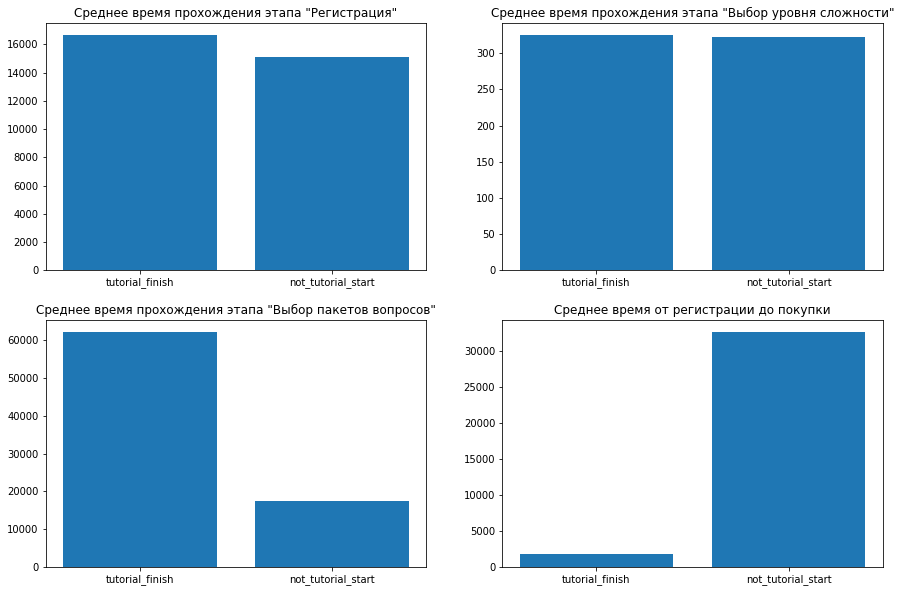

In [117]:
import matplotlib.pyplot as plt
import numpy as np

#визуализация систем координат
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

axes[0][0].bar(x=average_timedelta_users['status'], 
            height=average_timedelta_users['registration'],
            label='Время в секундах')
axes[0][0].set_title('Среднее время прохождения этапа "Регистрация"')

axes[0][1].bar(x=average_timedelta_users['status'], 
            height=average_timedelta_users['level_choice'],
            label='Время в секундах')
axes[0][1].set_title('Среднее время прохождения этапа "Выбор уровня сложности"')

axes[1][0].bar(x=average_timedelta_users['status'], 
            height=average_timedelta_users['pack_choice'],
            label='Время в секундах')
axes[1][0].set_title('Среднее время прохождения этапа "Выбор пакетов вопросов"')

axes[1][1].bar(x=average_timedelta_users['status'], 
            height=average_timedelta_users['purchase'],
            label='Время в секундах')
axes[1][1].set_title('Среднее время от регистрации до покупки')


*Определяем время обучения*

In [8]:
tutorial_finish_df = total_events_df[total_events_df["event_type"] == "tutorial_finish"]

first_tutorial_ids = tutorial_start_df_wo_duplicates["tutorial_id"].unique()
tutorial_finish_df = tutorial_finish_df[tutorial_finish_df["tutorial_id"].isin(first_tutorial_ids)]

tutorial_finish_df = tutorial_finish_df[["user_id", "start_time"]].rename(columns={"start_time": "tutorial_finish_time"})
merged_df_2 = tutorial_start_df_wo_duplicates.merge(tutorial_finish_df, on="user_id", how="inner")
merged_df_2["timedelta"] = (merged_df_2["tutorial_finish_time"] - merged_df_2["tutorial_start_time"])

print(merged_df_2["timedelta"].mean())
print(merged_df_2["timedelta"].describe())

0 days 00:03:53.174160732
count                         9830
mean     0 days 00:03:53.174160732
std      0 days 00:01:44.803217992
min                0 days 00:00:16
25%                0 days 00:02:28
50%                0 days 00:03:42
75%                0 days 00:05:08
max                0 days 00:10:06
Name: timedelta, dtype: object


*Определяем время между registration и level_choice*

In [9]:
level_choice_df = total_events_df[total_events_df["event_type"] == "level_choice"]
level_choice_df = level_choice_df[["user_id", "start_time"]].rename(columns={"start_time": "level_choice_time"})
merged_df_3 = registration_df.merge(level_choice_df, on="user_id", how="inner")
merged_df_3["timedelta"] = (merged_df_3["level_choice_time"] - merged_df_3["registration_time"])

print(merged_df_3["timedelta"].mean())
print(merged_df_3["timedelta"].describe())

0 days 07:10:19.169863342
count                         8342
mean     0 days 07:10:19.169863342
std      0 days 04:33:51.164488800
min                0 days 00:08:15
25%         0 days 03:53:16.500000
50%                0 days 06:03:28
75%         0 days 09:34:58.500000
max                1 days 18:48:25
Name: timedelta, dtype: object


*Считаем пользователей, которые завершили обучение и совершили оплату*

In [17]:
purchase_df_1 = purchase_df[purchase_df["user_id"].isin(users_with_finished_tutorial)]
percent_of_purchase_1 = purchase_df_1["user_id"].nunique() / len(users_with_finished_tutorial)

*Считаем средний размер платежа разных групп*

In [18]:
purchase_df_2 = purchase_df[purchase_df["user_id"].isin(set_users_not_finished_but_started_tutorial)]
#print(purchase_df_2["user_id"].nunique())
percent_of_purchase_2 = purchase_df_2["user_id"].nunique() / len(set_users_not_finished_but_started_tutorial)
purchase_df_2['amount'].mean()

104.9618320610687

*Определяем, насколько обучение сокращает время прохождения этапов игры*

*Ищем пользователей, прошедших обучение хотя бы раз*

In [49]:
users_with_finished_tutorial

array([27835, 27836, 27833, ..., 47753, 47755, 47756], dtype=int64)

In [48]:
users_with_finished_tutorial = total_events_df[total_events_df["event_type"] == "tutorial_finish"]["user_id"].unique()
purchase_df_1 = purchase_df[purchase_df["user_id"].isin(users_with_finished_tutorial)]
purchase_df_1

,purchase_id,user_id,start_time,amount,event_type
1171,16845,27845,2018-01-03 18:53:43,100,purchase
1175,16849,27910,2018-01-07 12:11:34,100,purchase
1176,16850,27940,2018-01-07 13:16:41,200,purchase
1178,16852,27981,2018-01-07 23:20:25,50,purchase
1179,16853,27969,2018-01-08 01:18:23,100,purchase
...,...,...,...,...,...
2767,18441,47498,2019-01-02 03:48:19,100,purchase
2768,18442,47647,2019-01-02 23:26:26,150,purchase
2769,18443,47554,2019-01-03 00:36:36,50,purchase
2774,18448,47742,2019-01-04 12:51:41,50,purchase


In [42]:
tutorial_finish_df = total_events_df[total_events_df['event_type'] == 'tutorial_finish']
tutorial_finish_df_wo_duplicates = tutorial_finish_df.sort_values("start_time").drop_duplicates("user_id")
tutorial_finish_df_wo_duplicates = tutorial_finish_df_wo_duplicates[["user_id"]]
tutorial_finish_df_wo_duplicates

,user_id
9,27835
11,27836
13,27833
16,27839
18,27834
...,...
66935,47747
66944,47751
66946,47753
66953,47755


In [53]:
users_with_started_tutorial = total_events_df[total_events_df["event_type"] == "tutorial_start"]["user_id"].unique()
all_users = total_events_df["user_id"].unique()
set_all_users = set(all_users)
set_users_not_started_tutorial = set_all_users.difference(set(users_with_started_tutorial))

{32771,
 32780,
 32781,
 32782,
 32783,
 32785,
 32788,
 32789,
 32791,
 32792,
 32793,
 32799,
 32802,
 32814,
 32820,
 32822,
 32823,
 32826,
 32829,
 32831,
 32834,
 32837,
 32838,
 32840,
 32842,
 32846,
 32848,
 32859,
 32861,
 32862,
 32864,
 32865,
 32866,
 32867,
 32868,
 32869,
 32877,
 32884,
 32886,
 32887,
 32891,
 32893,
 32898,
 32899,
 32902,
 32909,
 32912,
 32914,
 32923,
 32926,
 32929,
 32932,
 32936,
 32939,
 32940,
 32945,
 32946,
 32948,
 32951,
 32959,
 32960,
 32964,
 32966,
 32967,
 32968,
 32969,
 32975,
 32976,
 32977,
 32978,
 32980,
 32983,
 32990,
 32991,
 32994,
 32995,
 32998,
 33000,
 33001,
 33009,
 33010,
 33013,
 33015,
 33021,
 33024,
 33025,
 33027,
 33029,
 33030,
 33031,
 33032,
 33034,
 33036,
 33037,
 33040,
 33041,
 33043,
 33045,
 33046,
 33047,
 33052,
 33053,
 33056,
 33062,
 33063,
 33064,
 33066,
 33067,
 33068,
 33070,
 33071,
 33072,
 33073,
 33076,
 33078,
 33079,
 33080,
 33083,
 33086,
 33092,
 33097,
 33100,
 33101,
 33102,
 33103,


*Определяем время прохождения между этапами для пользователей, прошедших обучение*

In [67]:
registration_df = total_events_df[total_events_df['event_type'] == 'registration']
registration_df = registration_df[["user_id", "start_time"]].rename(columns={"start_time": "registration_time"})

tutorial_start_df = total_events_df[total_events_df['event_type'] == 'tutorial_start']
tutorial_start_df_wo_duplicates = tutorial_start_df.sort_values("start_time").drop_duplicates("user_id")
tutorial_start_df_wo_duplicates = tutorial_start_df_wo_duplicates[["user_id", "tutorial_id", "start_time"]].rename(columns={"start_time": "tutorial_start_time"})

merged_df = registration_df.merge(tutorial_start_df_wo_duplicates, on="user_id", how="inner")
merged_df["timedelta_1"] = (merged_df["tutorial_start_time"] - merged_df["registration_time"])

table = merged_df.filter(['user_id', 'timedelta_1'])

tutorial_finish_df = total_events_df[total_events_df["event_type"] == "tutorial_finish"]
first_tutorial_ids = tutorial_start_df_wo_duplicates["tutorial_id"].unique()

tutorial_finish_df = tutorial_finish_df[tutorial_finish_df["tutorial_id"].isin(first_tutorial_ids)]
tutorial_finish_df = tutorial_finish_df[["user_id", "start_time"]].rename(columns={"start_time": "tutorial_finish_time"})

merged_df_2 = tutorial_start_df_wo_duplicates.merge(tutorial_finish_df, on="user_id", how="inner")
merged_df_2["timedelta_2"] = (merged_df_2["tutorial_finish_time"] - merged_df_2["tutorial_start_time"])

table = table.merge(merged_df_2.filter(['user_id', 'timedelta_2']), on="user_id", how="inner")



##### Гипотеза 3

In [77]:
user_path_df = (total_events_df.groupby(["user_id"])["event_type"].apply(list).reset_index())

user_path_df["event_path"] = user_path_df["event_type"].apply(lambda x: " > ".join(x))

user_paths = (
    user_path_df.groupby(["event_path"])["user_id"]
    .nunique()
    .sort_values(ascending=False)
)

*Определим все возможные пути, когда после регистрации пользователь начинал обучение и посчитаем долю пользователей с такими путями от количества всех зарегистрированных пользователей*

In [79]:
user_paths_level_choice_tutorial_start = user_paths[user_paths.index.str.contains('level_choice > tutorial_start')]

user_paths_level_choice_tutorial_start_df = pd.DataFrame(user_paths_level_choice_tutorial_start)
count_user_paths_level_choice_tutorial_start = user_paths_level_choice_tutorial_start_df ['user_id'].sum()

registered_users_count = events_df[events_df["event_type"] == "registration"]["user_id"].nunique()

print(
    "Процент пользователей, начавших свое обучение после выбора уровня (от общего числа зарегистрировавшихся): {:.2%}".format(
        count_user_paths_level_choice_tutorial_start / registered_users_count
    )
)

Процент пользователей, начавших свое обучение после выбора уровня (от общего числа зарегистрировавшихся): 2.46%
